<a href="https://colab.research.google.com/github/bendavidsteel/trade-democratization/blob/master/trade_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import itertools
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this project we will be linking the [V-Dem dataset](https://www.v-dem.net/en) and the [CEPII Trade History dataset](http://www.cepii.fr/cepii/en/bdd_modele/bdd.asp) into a time series graph dataset, in an attempt to investigate how bilateral trade affects the democratization of nations over time.

In [17]:
dataset_path = os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization', 'dataset', 'raw')
# here we load the democracy indices from the V-Dem dataset
vdem_nodes = pd.read_csv(os.path.join(dataset_path, "V-Dem-CY-Core-v10.csv"))
vdem_nodes.head()

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,codingstart_contemp,codingend_contemp,codingstart_hist,codingend_hist,gapstart1,gapstart2,gapstart3,gapend1,gapend2,gapend3,COWcode,v2x_polyarchy,v2x_polyarchy_codelow,v2x_polyarchy_codehigh,v2x_polyarchy_sd,v2x_libdem,v2x_libdem_codelow,v2x_libdem_codehigh,v2x_libdem_sd,v2x_partipdem,v2x_partipdem_codelow,v2x_partipdem_codehigh,v2x_partipdem_sd,v2x_delibdem,v2x_delibdem_codelow,v2x_delibdem_codehigh,v2x_delibdem_sd,v2x_egaldem,v2x_egaldem_codelow,v2x_egaldem_codehigh,...,v2x_EDcomp_thick,v2x_EDcomp_thick_codelow,v2x_EDcomp_thick_codehigh,v2x_EDcomp_thick_sd,v2x_freexp,v2x_freexp_codelow,v2x_freexp_codehigh,v2x_freexp_sd,v2x_hosabort,v2x_hosinter,v2x_legabort,v2xcl_disc,v2xcl_disc_codelow,v2xcl_disc_codehigh,v2xcl_disc_sd,v2xcl_dmove,v2xcl_dmove_codelow,v2xcl_dmove_codehigh,v2xcl_dmove_sd,v2xcl_slave,v2xcl_slave_codelow,v2xcl_slave_codehigh,v2xcl_slave_sd,v2xel_elecparl,v2xel_elecpres,v2xex_elecleg,v2xlg_leginter,v2xme_altinf,v2xme_altinf_codelow,v2xme_altinf_codehigh,v2xme_altinf_sd,v2xps_party,v2xps_party_codelow,v2xps_party_codehigh,v2x_divparctrl,v2x_feduni,v2xca_academ,v2xca_academ_codelow,v2xca_academ_codehigh,v2xca_academ_sd
0,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.043,0.029,0.055,0.013,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,Mexico,MEX,3,1790,1790-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,Mexico,MEX,3,1791,1791-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,Mexico,MEX,3,1792,1792-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,Mexico,MEX,3,1793,1793-12-31,1,1,Viceroyalty of New Spain,1088,2019,1900.0,2019.0,1789.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,0.031,0.021,0.039,0.01,0.040,0.021,0.051,0.014,0.008,0.001,0.012,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006,0.002,0.008,0.007,0.175,0.096,0.277,0.644,0.0,0.0,0.0,0.115,0.07,0.201,0.631,0.385,0.265,0.524,0.64,0.064,0.03,0.125,0.645,0,0,0.0,0.0,0.134,0.064,0.244,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [18]:
tradhist_gdppop = pd.read_excel(os.path.join(dataset_path, "TRADHIST_GDP_POP.xlsx"))
tradhist_gdppop.head()

,iso,year,GDP,SOURCE_GDP,POP,SOURCE_POP,SOURCE_SH_PRIM,SOURCE_SH_SECD,SH_PRIM,SH_SECD
0,MMR,1827,NaN,NaN,3605.399902,MADDISON_IPO,NaN,NaN,NaN,NaN
1,SOM,1827,NaN,NaN,1077.427124,MADDISON_IPO,NaN,NaN,NaN,NaN
2,ADEN,1827,NaN,NaN,2627.580078,MADDISON_IPO,NaN,NaN,NaN,NaN
3,MOZ,1827,NaN,NaN,2319.700684,MADDISON_IPO,NaN,NaN,NaN,NaN
4,PRI,1827,NaN,NaN,305.633331,MADDISON_IPO,NaN,NaN,NaN,NaN


In [19]:
# now we load the time invariant bilateral data from the CEPII TradHist dataset
tradhist_timeinvar = pd.read_excel(os.path.join(dataset_path, "TRADHIST_GRAVITY_BILATERAL_TIME_INVARIANT.xlsx"))
tradhist_timeinvar.head()

,iso_o,iso_d,Distw,Dist_coord,Evercol,Comlang,Contig
0,2SICIL,AUTHUN,NaN,837.066180,0,0,0
1,2SICIL,BEL,NaN,1349.682430,0,0,0
2,2SICIL,CHL,NaN,11978.672481,0,0,0
3,2SICIL,ESP,NaN,1514.852764,0,0,0
4,2SICIL,FRA,NaN,1291.794085,0,0,0


In [20]:
# then load the three files that constitute the bilateral historical non trade related data such as distances between countries and colonial status
tradhist_timevar_frames = []
for idx in range(1, 4):
    tradhist_timevar_frames.append(pd.read_excel(os.path.join(dataset_path, "TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))))
tradhist_timevar = pd.concat(tradhist_timevar_frames)
tradhist_timevar.head()

,iso_o,iso_d,year,SeaDist_SHRT,SeaDist_2CST,Curcol,Metro,Colo
0,2SICIL,AUTHUN,1838,1790.884033,1790.884033,0,NaN,NaN
1,2SICIL,BEL,1834,4463.319824,4463.319824,0,NaN,NaN
2,2SICIL,BEL,1835,4463.319824,4463.319824,0,NaN,NaN
3,2SICIL,BEL,1836,4463.319824,4463.319824,0,NaN,NaN
4,2SICIL,BEL,1837,4463.319824,4463.319824,0,NaN,NaN


In [21]:
tradhist_bitrade_frames = []
for idx in range(1, 4):
    tradhist_bitrade_frames.append(pd.read_excel(os.path.join(dataset_path, "TRADHIST_BITRADE_BITARIFF_{}.xlsx".format(idx))))
tradhist_bitrade = pd.concat(tradhist_bitrade_frames)
tradhist_bitrade.head()

,iso_o,iso_d,year,FLOW,FLOW_0,SOURCE_TF,BITARIFF
0,2SICIL,AUTHUN,1838,492920.687500,NaN,RIC_IP,NaN
1,2SICIL,BEL,1834,38164.500000,NaN,RIC_IP,NaN
2,2SICIL,BEL,1835,30052.339844,NaN,RIC_IP,NaN
3,2SICIL,BEL,1836,44906.539062,NaN,RIC_IP,NaN
4,2SICIL,BEL,1837,33957.269531,NaN,RIC_IP,NaN


Previous studies how shown that geographical closeness and colonizer/colony status affects the diffusion of democracy. It seems likely following from this that trade would result in some democratization diffusion effect also.

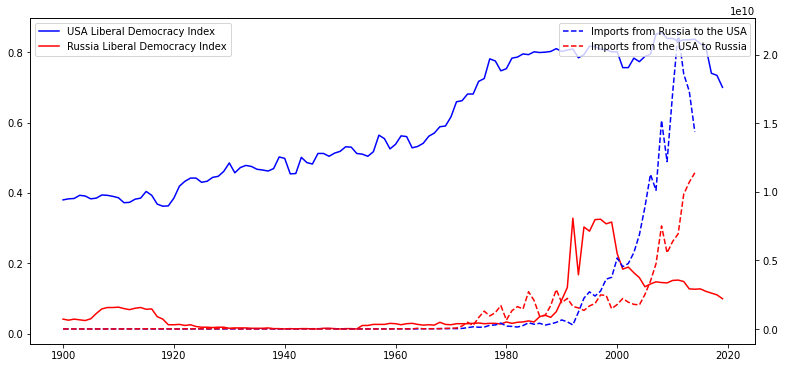

In [26]:
# TradHist dataset has data for USSR separate than from Russia
# USA : USA
# Russia: RUS, USSR (VDem uses RUS only, TradHist uses RUS and USSR)
colours = ['r', 'b']

# get high level indicators of democracy
ctry_demind = {}
ctry_demind["USA"] = vdem_nodes[(vdem_nodes['country_text_id'] == "USA") & (vdem_nodes['year'] >= vdem_nodes['codingstart_contemp'])][['year', 'v2x_libdem']]
ctry_demind["RUS"] = vdem_nodes[(vdem_nodes['country_text_id'] == "RUS") & (vdem_nodes['year'] >= vdem_nodes['codingstart_contemp'])][['year', 'v2x_libdem']]


# get imports of one country from the other
ctry_trade = {}
ctry_trade["USA"] = tradhist_bitrade[((tradhist_bitrade['iso_o'] == "RUS") | (tradhist_bitrade['iso_o'] == "USSR"))
                                     & (tradhist_bitrade['iso_d'] == "USA") 
                                     & (tradhist_bitrade['year'] >= 1900)][['year', 'FLOW']].sort_values(by=['year'])
ctry_trade["RUS"] = tradhist_bitrade[(tradhist_bitrade['iso_o'] == "USA")
                                     & ((tradhist_bitrade['iso_d'] == "RUS") | (tradhist_bitrade['iso_d'] == "USSR"))
                                     & (tradhist_bitrade['year'] >= 1900)][['year', 'FLOW']].sort_values(by=['year'])

# plot the data
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()

ax1.plot(ctry_demind["USA"].values[:, 0], ctry_demind["USA"].values[:, 1], 'b-', label="USA Liberal Democracy Index")
ax2.plot(ctry_trade["USA"].values[:, 0], ctry_trade["USA"].values[:, 1], 'b--', label="Imports from Russia to the USA")
ax1.plot(ctry_demind["RUS"].values[:, 0], ctry_demind["RUS"].values[:, 1], 'r-', label="Russia Liberal Democracy Index")
ax2.plot(ctry_trade["RUS"].values[:, 0], ctry_trade["RUS"].values[:, 1], 'r--', label="Imports from the USA to Russia")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
plt.show()

The figure seems to show some non-linear relationship between trade and liberal democracy index. The casuality direction of this is not clear however.

These figures show us that normalising the trade data will be important to prevent any relationships being overshadowed by GDP growth, even if GDP growth will likely be another key factor that affects democratization. We will therefore be using GDP and population as a node feature, and normalising trade data by the GDP of a country at that time.

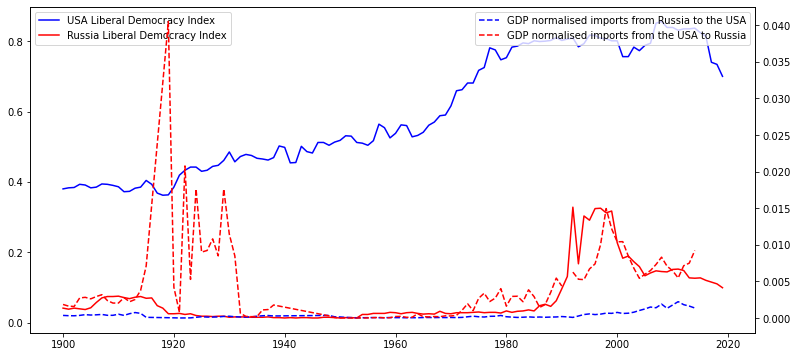

In [27]:
ctry_gdp_trade = {}
usa_gdp = tradhist_gdppop[(tradhist_gdppop['iso'] == 'USA') & (tradhist_gdppop['year'] >= 1900)][['year', 'GDP']].sort_values(by=['year'])
ctry_gdp_trade['USA'] = pd.merge(usa_gdp, ctry_trade['USA'], how='inner')
rus_gdp = tradhist_gdppop[((tradhist_gdppop['iso'] == 'RUS') | (tradhist_gdppop['iso'] == 'USSR')) & (tradhist_gdppop['year'] >= 1900)][['year', 'GDP']].sort_values(by=['year'])
ctry_gdp_trade['RUS'] = pd.merge(rus_gdp, ctry_trade['RUS'], how='inner')

# plot the data
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()

ax1.plot(ctry_demind["USA"].values[:, 0], ctry_demind["USA"].values[:, 1], 'b-', label="USA Liberal Democracy Index")
ax2.plot(ctry_gdp_trade["USA"][['year']].values[:, 0], ctry_gdp_trade["USA"][['FLOW']].values[:, 0] / ctry_gdp_trade["USA"][['GDP']].values[:, 0], 'b--', label="GDP normalised imports from Russia to the USA")
ax1.plot(ctry_demind["RUS"].values[:, 0], ctry_demind["RUS"].values[:, 1], 'r-', label="Russia Liberal Democracy Index")
ax2.plot(ctry_gdp_trade["RUS"][['year']].values[:, 0], ctry_gdp_trade["RUS"][['FLOW']].values[:, 0] / ctry_gdp_trade["RUS"][['GDP']].values[:, 0], 'r--', label="GDP normalised imports from the USA to Russia")

ax1.legend(loc = "upper left")
ax2.legend(loc = "upper right")
plt.show()

This normalised data does seems to show a significant correlation between Russian imports of American goods with democratization.

We now need to find a way of linking the two datasets. The trade history dataset uses the ISO country codes. However the V-Dem dataset seems to have its own country numbering system, and the three letter shortened name isn't specified in the reference manual to be the ISO name. Lets look at the union of the country codes for the two datasets and the country codes which are unique to each dataset.

In [ ]:
vdem_country_codes = set(vdem_nodes['country_text_id'].unique())
tradhist_country_codes = set(tradhist_timevar['iso_o'].unique())
shared_codes = vdem_country_codes & tradhist_country_codes
vdem_unique_codes = vdem_country_codes - shared_codes
tradhist_unique_codes = tradhist_country_codes - shared_codes

def print_set(code_set, per_line = 20):
    code_ordered = sorted(list(code_set))
    for i in range(0, len(code_ordered), per_line):
        print(code_ordered[i:i + per_line])

print("Shared Country Codes:")
print_set(shared_codes)
print()
print("VDem Only Country Codes:")
print_set(vdem_unique_codes)
print()
print("TradHist Only Country Codes:")
print_set(tradhist_unique_codes)
print()


Shared Country Codes:
['AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA']
['BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU']
['DJI', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB']
['GNQ', 'GRC', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN']
['KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MDG', 'MDV', 'MEX']
['MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN']
['PAK', 'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'QAT', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLB', 'SLE', 'SLV'

The major difference seems to be that the V-Dem dataset uses a consistent code for the varying regimes of a 'country', compared to the CEPII dataset using for example USSR for the Soviet Union instead of continuing to use RUS. We need to find if there are any other examples of this and create a mapping system. We will not include trade participants from the trade dataset that are current subareas of sovereignties, as they provide no additional data to correlate with nation democratization given that their owning sovereignty is already featured in the dataset. However we will lump together formerly separate sovereignties that have no additional coding in the V-Dem dataset, such as Prince Edward Island and Canada.

For former countries that cover the land of multiple modern countries, we will associate the trade of those countries at the time with all of the modern countries in their former land area.

In [32]:
def get_mapping(vdem_nodes, tradhist_timevar):   

    vdem_country_codes = set(vdem_nodes['country_text_id'].unique())
    tradhist_country_codes = set(tradhist_timevar['iso_o'].unique())
    shared_codes = vdem_country_codes & tradhist_country_codes

    mapped_codes = [['RUS', 'USSR'], ['YEM', 'ADEN'], ['CAF', 'AOFAEF', 'FRAAEF'], ['TCD', 'AOFAEF', 'FRAAEF'], ['COD', 'AOFAEF', 'FRAAEF'], ['HRV', 'AUTHUN', 'YUG'], ['SVK', 'CZSK', 'AUTHUN'], 
                ['SVN', 'AUTHUN', 'YUG'], ['UKR', 'AUTHUN', 'USSR'], ['ALB', 'AUTHUN'], ['BIH', 'AUTHUN', 'YUG'], ['MNE', 'AUTHUN', 'YUG'], ['CAN', 'CANPRINCED', 'CANQBCONT', 'NFLD'], 
                ['CZE', 'CZSK', 'AUTHUN'], ['DDR', 'EDEU'], ['MYS', 'FEDMYS', 'UNFEDMYS', 'GBRBORNEO'], ['BFA', 'FRAAOF'], ['GNQ', 'FRAAOF'], ['LUX', 'ZOLL'], 
                ['ZZB', 'ZANZ', 'GBRAFRI'], ['ZAF', 'ZAFTRA', 'ZAFORA', 'ZAFNAT', 'ZAPCAF', 'GBRAFRI'], ['MKD', 'YUG'], ['SRB', 'YUG'], ['POL', 'USSR'], ['COM', 'MYT'], ['ROU', 'ROM'], 
                ['MWI', 'RHOD', 'GBRAFRI'], ['ZMB', 'RHOD', 'GBRAFRI'], ['ZWE', 'RHOD', 'GBRAFRI'], ['SGP', 'STRAITS'], ['DEU', 'WDEU'], ['SML', 'GBRSOM', 'ITASOM'], ['GBR', 'ULSTER'], 
                ['RWA', 'RWABDI'], ['SOM', 'ITASOM'], ['MAR', 'MARESP'], ['FRA', 'OLDENB'], ['DNK', 'SCHLES'], ['LBN', 'SYRLBN', 'OTTO'], ['SYR', 'SYRLBN'], ['CYP', 'OTTO', 'GBRMEDI'], 
                ['TUR', 'OTTO'], ['STP', 'PRTAFRI'], ['AGO', 'PRTAFRI'], ['MOZ', 'PRTAFRI'], ['GNB', 'PRTWAFRI'], ['KHM', 'INDOCHI'], ['LAO', 'INDOCHI'], ['VNM', 'INDOCHI'], 
                ['ERI', 'ITAEAFRI', 'GBRAFRI'], ['TTO', 'GBRWINDIES'], ['SLE', 'GBRWAFRI'], ['GMB', 'GBRWAFRI'], ['TGO', 'GBRWAFRI'], ['EGY', 'OTTO'],
                ['PNG', 'GBRPAPUA'], ['MLT', 'GBRMEDI'], ['BGD', 'GBRIND'], ['BTN', 'GBRIND'], ['IND', 'GBRIND'], ['MDV', 'GBRIND'], ['NPL', 'GBRIND'], ['PAK', 'GBRIND'], 
                ['LKA', 'GBRIND'], ['CMR', 'GBRAFRI', 'FRAAFRI'], ['KEN', 'GBRAFRI'], ['SYC', 'GBRAFRI'], ['SDN', 'GBRAFRI'], ['UGA', 'GBRAFRI'], ['LSO', 'GBRAFRI'], 
                ['SWZ', 'GBRAFRI']]

    # validate my matches
    code_count = {}
    for codes in mapped_codes:
        matched_to_vdem = 0
        for code in codes:
            if len(code) == 3:
                if code in vdem_country_codes:
                    if code in code_count:
                        code_count[code] += 1
                    else:
                        code_count[code] = 1
                    matched_to_vdem += 1

        if matched_to_vdem == 0:
            raise ValueError("{} country code set matched to no VDem node".format(codes))
        elif matched_to_vdem > 1:
            raise ValueError("{} country code set matched to more than one VDem node".format(codes))

        if codes[0] not in vdem_country_codes:
            raise ValueError("VDem code should be first in list {}.".format(codes))

    for code in code_count:
        if code_count[code] != 1:
            raise ValueError("VDem code {} matched to more than one country code set".format(code))

    for code in shared_codes:
        if code not in code_count:
            mapped_codes.append([code])

    return mapped_codes

#mapped_codes = get_mapping(vdem_nodes, tradhist_timevar)

#print_set(mapped_codes, 10)

Now that we have a mapping between the two datasets we can start putting them together. We will only be using data from 1900 to 2014, as before 1900 the VDem dataset is noted to be much less accurate, and trade data is increasingly absent for smaller nations. 

This is where we will first use our graph learning library of choice, PyTorch Geometric. PyTorch Geometric provides a base class with which to structure the compilation of a dataset.

In [5]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter==2.0.4+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==0.6.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==1.5.5+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==1.2.0+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 12.3MB 307kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 21.6MB 1.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 22.0MB 1.5MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 6.3MB 2.1MB/s 
     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 235kB 7.7MB/s 
     |████████████████████████████████| 2.1MB 8.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.0-cp36-none-any.whl size=296339 sha256=ca77d2df7d64d356fa6c6ae5e74c44d1f3b1cfbc4030da4d7ad14f74e20f4f76
  Stored in directory: /root/.cache/pip/whe

In [28]:
import torch
import torch_geometric as geo
import tqdm

We will initially create a simple model trying to predict next year's democracy indicators from this year's democracy indicators, alongside trade and other geopolitical data. This has the disadvantage compared to a more traditional RNN of not having long term memory, but it will create a good baseline.

In [31]:
def get_last_valid(df, col):
    valid_rows = df[df[col].isnull() == False]
    if (len(valid_rows) > 0):
        return valid_rows.sort_values('year')[col].values[-1]
    else:
        return 0

In [33]:
class TradeDemoYearByYearDataset(geo.data.InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):

        self.norm_stats = os.path.join(root, "processed", "norm_stats.pt")
        self.node_dict = os.path.join(root, "processed", "node_dict.pt")
        self.year_start = 1900
        self.year_end = 2015

        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        # vdem dataset
        files.append("V-Dem-CY-Core-v10.csv")
        # gdp and population data
        files.append("TRADHIST_GDP_POP.xlsx")
        # time invariant bilateral data such as distance, common language
        files.append("TRADHIST_GRAVITY_BILATERAL_TIME_INVARIANT.xlsx")
        # time variant non trade bilateral data such as colony status
        for idx in range(1, 4):
            files.append("TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))
        # historical bilateral trade and tariff data
        for idx in range(1, 4):
            files.append("TRADHIST_BITRADE_BITARIFF_{}.xlsx".format(idx))

        return files

    @property
    def processed_file_names(self):
        return ['traddem.pt']

    def process(self):
        # Read data into Data object.
        vdem_nodes = pd.read_csv(os.path.join(self.raw_dir, "V-Dem-CY-Core-v10.csv"))

        tradhist_gdppop = pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_GDP_POP.xlsx"))

        tradhist_timeinvar = pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_GRAVITY_BILATERAL_TIME_INVARIANT.xlsx"))

        tradhist_timevar_frames = []
        for idx in range(1, 4):
            tradhist_timevar_frames.append(pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_GRAVITY_BILATERAL_TIME_VARIANT_{}.xlsx".format(idx))))
        tradhist_timevar = pd.concat(tradhist_timevar_frames)

        tradhist_bitrade_frames = []
        for idx in range(1, 4):
            tradhist_bitrade_frames.append(pd.read_excel(os.path.join(self.raw_dir, "TRADHIST_BITRADE_BITARIFF_{}.xlsx".format(idx))))
        tradhist_bitrade = pd.concat(tradhist_bitrade_frames)

        country_mapping = get_mapping(vdem_nodes, tradhist_timevar)

        num_countries = len(country_mapping)
        num_node_features = 2 + 5 # include GDP and population data, and democracy data from last year
        num_node_targets = 5 # 5 main indicators of democracy from the VDem dataset
        num_edge_features = 7 # Trade flow, current colony relationship, ever a colony, distance, maritime distance, common language, and shared border

        all_years = []
        years_metadata = []
        year_start = self.year_start
        year_end = self.year_end

        for year_idx, year in tqdm.tqdm(enumerate(range(year_start, year_end))):

            year_metadata = {}
            year_metadata["year"] = year

            year_edge_attr = []
            year_edge_index = []

            node_features = []
            node_target = []
            mapping_to_node_indexes = {}

            vdem_this_year = vdem_nodes[(vdem_nodes['year'] == year)]
            vdem_next_year = vdem_nodes[(vdem_nodes['year'] == year + 1)]

            gdppop_year_span = tradhist_gdppop[tradhist_gdppop['year'].isin(list(range(year_start, year + 1)))]

            for country_idx, country_codes in enumerate(country_mapping):
                # check if this year and next is coded in VDem
                vdem_this_year_cty = vdem_this_year[(vdem_this_year['country_text_id'] == country_codes[0])][['v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem', 'v2x_egaldem']]
                vdem_next_year_cty = vdem_next_year[(vdem_next_year['country_text_id'] == country_codes[0])][['v2x_polyarchy', 'v2x_libdem', 'v2x_partipdem', 'v2x_delibdem', 'v2x_egaldem']]
                if ((len(vdem_this_year_cty) == 0) | \
                    (len(vdem_next_year_cty) == 0) | \
                    (vdem_this_year_cty.isnull().values.any()) | \
                    (vdem_next_year_cty.isnull().values.any())):
                    continue

                country_features = np.zeros((num_node_features, 1))
                country_targets = np.zeros((num_node_targets, 1))

                # look for last time there was valid value, use 0 otherwise
                gdppop_year_cty = gdppop_year_span[gdppop_year_span['iso'].isin(country_codes)]
                country_features[0] = get_last_valid(gdppop_year_cty, 'GDP')
                country_features[1] = get_last_valid(gdppop_year_cty, 'POP')

                country_features[2:] = vdem_this_year_cty.values.reshape(-1, 1)
                country_targets[:] = vdem_next_year_cty.values.reshape(-1, 1)

                mapping_to_node_indexes[country_idx] = len(node_features)
                node_features.append(np.nan_to_num(country_features))
                node_target.append(np.nan_to_num(country_targets))

            
            year_metadata["node_mapping"] = mapping_to_node_indexes

            timevar_time_span = tradhist_timevar[tradhist_timevar['year'].isin(list(range(year_start, year + 1)))]
            bitrade_time_span = tradhist_bitrade[tradhist_bitrade['year'].isin(list(range(year_start, year + 1)))]

            # now that all nodes are in this graph have set indexes, we can add the edges with the correct indexes too
            for country_a_idx, node_a_idx in mapping_to_node_indexes.items():

                country_codes_a = country_mapping[country_a_idx]

                time_invar_cty = tradhist_timeinvar[tradhist_timeinvar['iso_d'].isin(country_codes_a)]

                timevar_span_cty = timevar_time_span[timevar_time_span['iso_d'].isin(country_codes_a)]
                bitrade_span_cty = bitrade_time_span[bitrade_time_span['iso_d'].isin(country_codes_a)]

                for country_b_idx, node_b_idx in mapping_to_node_indexes.items():
                    # self links don't really make sense to include in the dataset
                    if country_a_idx == country_b_idx:
                        continue
                    
                    country_codes_b = country_mapping[country_b_idx]

                    bilateral_attr = np.zeros((num_edge_features, 1))
                    # for situations where we have multiple trade links two mapped countries due to how we define a country, we will simply take the last link for now
                    time_invar_attrs = time_invar_cty[time_invar_cty['iso_o'].isin(country_codes_b)]
                    if ((len(time_invar_attrs) == 0) |\
                        (vdem_this_year_cty.isnull().values.all())):
                        continue
                    bilateral_attr[:4] = time_invar_attrs[['Dist_coord', 'Evercol', 'Comlang', 'Contig']].values[-1].reshape(-1, 1)

                    timevar_span_link = timevar_span_cty[timevar_span_cty['iso_o'].isin(country_codes_b)]
                    bitrade_span_link = bitrade_span_cty[bitrade_span_cty['iso_o'].isin(country_codes_b)]

                    bilateral_attr[4] = get_last_valid(timevar_span_link, 'SeaDist_2CST')
                    bilateral_attr[5] = get_last_valid(timevar_span_link, 'Curcol')
                    bilateral_attr[6] = get_last_valid(bitrade_span_link, 'FLOW')

                    edge_index = [node_b_idx, node_a_idx]

                    year_edge_attr.append(np.nan_to_num(bilateral_attr))
                    year_edge_index.append(edge_index)

            year_graph = geo.data.Data(x=torch.tensor(node_features, dtype=torch.float32).view(-1, num_node_features), 
                                       y=torch.tensor(node_target, dtype=torch.float32).view(-1, num_node_targets), 
                                       edge_index=torch.tensor(year_edge_index, dtype=torch.long).T, 
                                       edge_attr=torch.tensor(year_edge_attr, dtype=torch.float32).view(-1, num_edge_features))

            all_years.append(year_graph)
            years_metadata.append(year_metadata)

        # get normalization stats
        # for completely unbiased test we should only get training set stats but will pass on that for this
        stacked_x = torch.cat(list([graph.x for graph in all_years]), 0)
        stacked_y = torch.cat(list([graph.y for graph in all_years]), 0)
        stacked_attrs = torch.cat(list([graph.edge_attr for graph in all_years]), 0)

        x_mean = torch.mean(stacked_x, 0)
        x_std = torch.std(stacked_x, 0)
        y_mean = torch.mean(stacked_y, 0)
        y_std = torch.std(stacked_y, 0)
        attr_mean = torch.mean(stacked_attrs, 0)
        attr_std = torch.std(stacked_attrs, 0)

        for graph in all_years:
            graph.x = (graph.x - x_mean) / x_std
            graph.y = (graph.y - y_mean) / y_std
            graph.edge_attr = (graph.edge_attr - attr_mean) / attr_std

        # save stats for later use
        torch.save({"x_mean": x_mean, "x_std": x_std, "y_mean": y_mean, "y_std": y_std, "attr_mean": attr_mean, "attr_std": attr_std}, self.norm_stats)
        torch.save(years_metadata, self.node_dict)

        data, slices = self.collate(all_years)
        torch.save((data, slices), self.processed_paths[0])

    def get_norm_stats(self):
        return torch.load(self.norm_stats)

Now that the dataset has been created, we need to shuffle, partition, and load the dataset into batches using the PyTorch Geometric data loader.

In [34]:

dataset = TradeDemoYearByYearDataset(os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization', 'dataset'))
dataset.shuffle()

# split into three sets
num_train = int(len(dataset) * 0.8)
num_val = int(len(dataset) * 0.1)
num_test = int(len(dataset) * 0.1)

train_set = dataset[:num_train]
val_set = dataset[num_train:num_train+num_val]
test_set = dataset[-num_test:]

# load into batches
train_loader = geo.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = geo.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = geo.data.DataLoader(test_set, batch_size=32, shuffle=True)

Processing...


115it [4:48:40, 150.61s/it]


Done!


Now we will define a simple graph network model that will predict next years democratization level given a range of variables for this year.

In [9]:
class RegressionGraphNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_outputs):
        super(RegressionGraphNet, self).__init__()
        # we will use the edge conditioned convolution (NNConv) as this allows more than 1 edge feature
        # while also not requiring inputs to be scaled between 0 and 1

        hidden_layer_size = 5

        # NNConv requires a layer to transform the dimensionality of edge features to the required size
        lin1 = torch.nn.Linear(num_edge_features, num_node_features * hidden_layer_size)

        # arbitrarily using 16 as hidden layer size
        self.conv1 = geo.nn.NNConv(num_node_features, hidden_layer_size, lin1)
        self.lin1 = torch.nn.Linear(hidden_layer_size, num_outputs)

    def forward(self, data):
        # weights are by default floats
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x = self.conv1(x, edge_index, edge_attr)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, p=0.6, training=self.training)
        x = self.lin1(x)

        # final activation is linear as this is for regression
        return x

We now create an instance of the model and optimizer:

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RegressionGraphNet(dataset.num_features, dataset.num_edge_features, dataset[0].y.size(1))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

Define our training and test calls

In [11]:
def train():
    model.train()
    loss_all = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        label = batch.y
        # good loss for regression problems
        loss = torch.nn.functional.smooth_l1_loss(out, label)
        loss.backward()
        loss_all += loss.item()
        optimizer.step()
    return loss_all / num_train

@torch.no_grad()
def test(loader, state_dict=None):

    if not state_dict is None:
        model.load_state_dict(state_dict)

    model.eval()
    num_batches = 0
    loss_all = 0
    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        label = batch.y
        # good loss for regression problems
        loss = torch.nn.functional.smooth_l1_loss(pred, label)
        loss_all += loss
        num_batches += 1
    return loss_all / num_batches


In [12]:
MAX_EPOCHS = 10000
min_val_loss = float("inf")
epochs_since = 0
NUM_NON_DECREASING = 100
for epoch in range(MAX_EPOCHS):
    train_loss = train()
    val_loss = test(val_loader)

    if epoch % 5 == 0:
        print('Epoch: {}, Train Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, train_loss, val_loss))

    if val_loss < min_val_loss:
        best_model = model.state_dict()
        min_val_loss = val_loss
        epochs_since = 0

    epochs_since += 1
    if epochs_since > NUM_NON_DECREASING:
        print("Early stopping engaged")
        break


Epoch: 0, Train Loss: 0.3829, Validation Loss: 26.1032
Epoch: 5, Train Loss: 0.0814, Validation Loss: 13.3514
Epoch: 10, Train Loss: 0.0314, Validation Loss: 8.2897
Epoch: 15, Train Loss: 0.0204, Validation Loss: 5.2978
Epoch: 20, Train Loss: 0.0165, Validation Loss: 3.7162
Epoch: 25, Train Loss: 0.0145, Validation Loss: 2.9844
Epoch: 30, Train Loss: 0.0131, Validation Loss: 2.5904
Epoch: 35, Train Loss: 0.0123, Validation Loss: 2.1812
Epoch: 40, Train Loss: 0.0115, Validation Loss: 1.9356
Epoch: 45, Train Loss: 0.0110, Validation Loss: 1.7126
Epoch: 50, Train Loss: 0.0107, Validation Loss: 1.5901
Epoch: 55, Train Loss: 0.0102, Validation Loss: 1.5001
Epoch: 60, Train Loss: 0.0097, Validation Loss: 1.3006
Epoch: 65, Train Loss: 0.0092, Validation Loss: 1.1678
Epoch: 70, Train Loss: 0.0089, Validation Loss: 1.0611
Epoch: 75, Train Loss: 0.0086, Validation Loss: 0.9676
Epoch: 80, Train Loss: 0.0082, Validation Loss: 0.9027
Epoch: 85, Train Loss: 0.0080, Validation Loss: 0.8009
Epoch: 90,

In [13]:
test_loss = test(test_loader, state_dict=best_model)
print('Final Test Loss: {:.4f}'.format(test_loss))

Final Test Loss: 0.2681


In [15]:
torch.save(best_model, os.path.join('/', 'content', 'drive', 'My Drive', 'projects', 'trade_democratization', 'best_model_non_recurrent.pkl'))

After tuning hyperparameters this seems to be a good final test set loss. 